In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import umap

from neuropacks import ECOG
from pyuoi.decomposition import UoI_NMF 
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize 

from utils import *
%matplotlib inline

In [2]:
data_path = '/storage/data/ecog/r32_b7.mat'
grid_path = '/storage/data/ecog/grdid.mat'
ecog = ECOG(
    data_path=data_path,
    grid_path=grid_path
)

In [3]:
Y = ecog.get_response_matrix(
    bounds=(40, 60),
    band='HG'
)

In [4]:
# kill the dead indices
dead_indices = [19, 21, 0]

In [5]:
Y = Y + np.abs(np.min(Y, axis=0, keepdims=True))
Y[:, dead_indices] = 0
# Y[Y < 0] = 0

# Multiple Ranks

In [62]:
uoi = UoI_NMF(
    n_boots=30,
    ranks=[20],
    nmf_max_iter=1000)

In [63]:
uoi.fit(Y)

UoI_NMF(cluster=DBSCAN(algorithm='auto', eps=0.5, leaf_size=30,
                       metric='euclidean', metric_params=None, min_samples=15.0,
                       n_jobs=None, p=None),
        cons_meth=<function mean at 0x7f4457bf9290>, db_algorithm=None,
        db_eps=None, db_leaf_size=None, db_metric=None, db_metric_params=None,
        db_min_samples=None, logger=None, n_boots=30,
        nmf=NMF(alpha=0.0, beta_loss='kullback-leibler', init='random',
                l1_ratio=0.0, max_iter=1000, n_components=20, random_state=None,
                shuffle=False, solver='mu', tol=0.0001, verbose=0),
        nmf_beta_loss=None, nmf_init=None, nmf_max_iter=None, nmf_solver=None,
        nmf_tol=None,
        nnreg=<function UoI_NMF_Base.__initialize.<locals>.<lambda> at 0x7f443c2d9050>,
        random_state=None, ranks=(20,), use_dissimilarity=True)

In [64]:
uoi.components_.shape

(11, 128)

In [65]:
uoi.dissimilarity_

array([0.09586922])

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(uoi.bases_samples_)
clusters = uoi.bases_samples_labels_

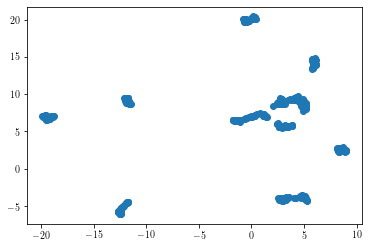

In [59]:
plt.scatter(embedding[:, 0], embedding[:, 1])

(<Figure size 1080x648 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f443be28950>,
       dtype=object))

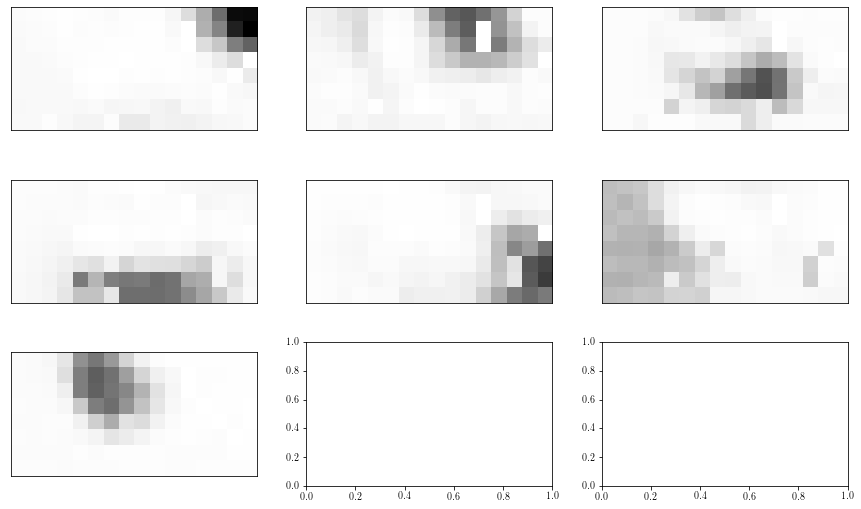

In [61]:
plot_ecog_bases(uoi.components_, ecog)

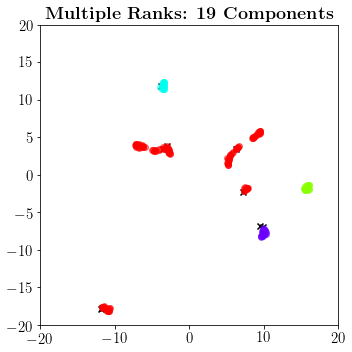

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

cluster_ids = np.unique(clusters)
n_clusters = cluster_ids.size - 1

for idx, c_id in enumerate(cluster_ids):
    group = np.argwhere(clusters == c_id).ravel()
    bases = embedding[group]
    
    if c_id == -1:
        ax.scatter(bases[:, 0], bases[:, 1], marker='x', color='k')
    else:
        ax.scatter(bases[:, 0], bases[:, 1], alpha=0.5,
                   color=plt.get_cmap('hsv')(int(255 * c_id / n_clusters)))

ax.tick_params(labelsize=15)
ax.set_ylim([-20, 20])
ax.set_xlim(ax.get_ylim())
ax.set_title(r'\textbf{Multiple Ranks: 19 Components}', fontsize=18)
plt.tight_layout()
# plt.savefig('nmf_embedding_multiple_ranks.pdf')